# Individual Assignment 1: Applications of NL(X) and LLMs

## Gamestop Stock Price Prediction

### Meghan Holquist
#### 2/13/24

In [162]:
#import relevant packages
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Accessing the Data

Stock data (taken from yahoo finance)

In [163]:
#import stock information from yahoo finance. 
yf.pdr_override()

#define the ticker were looking for 
stock_ticker = ['GME']

#define the start and end dates we're looking for - only going to august bc thats the end period of testing
stock_start_date = datetime.date(2021,1,4)
stock_end_date = datetime.date(2021, 8, 31)

#access the data 
stock_df = pdr.get_data_yahoo(stock_ticker, start = stock_start_date, end = stock_end_date).reset_index()
stock_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000


In [164]:
# need to do some pre-processing
# I am assuming we are making these predictions at the start of every day. 
# therefore, I need to create features that capture the previous day's information linked to the current date

# Create a new column 'Previous_Close' with the closing price from the previous day
stock_df['Previous_Close'] = stock_df['Close'].shift(1)

# Create a new column 'Previous_Volume' with the volume from the previous day
stock_df['Previous_Volume'] = stock_df['Volume'].shift(1)

# Drop NaN values resulting from the shift- just the first day bc there is no previous day for that 
stock_df = stock_df.dropna()

stock_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Previous_Close,Previous_Volume
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000,4.3125,40090000.0
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800,4.3425,19846000.0
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200,4.5900,24224800.0
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000,4.5200,24517200.0
5,2021-01-11,4.8525,5.1625,4.7525,4.9850,4.9850,59632000,4.4225,25928000.0


Reddit Data with posts and sentiment analysis information

In [165]:
#load in the dataset for sentiment and posts 
gamestop = pd.read_csv('rGME_dataset_features.csv', low_memory=False)
gamestop.head()

,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0
3,3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,...,1,0,0,0,0,0,0,0,0,0
4,4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,...,0,0,0,1,0,0,0,0,0,0


In [166]:
gamestop.columns

Index(['Unnamed: 0', 'id', 'title', 'url', 'score', 'author', 'num_comments',
       'date', 'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title',
       'clean_text', 'char_count', 'word_count', 'word_count_cln',
       'stopword_count', 'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP',
       '_ADJ', '_DET', '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV',
       '_PART', '_amod', '_ROOT', '_punct', '_advmod', '_auxpass',
       '_nsubjpass', '_ccomp', '_acomp', '_neg', '_nsubj', '_aux', '_agent',
       '_det', '_pobj', '_prep', '_csubj', '_nummod', '_attr', '_acl',
       '_relcl', '_dobj', '_pcomp', '_xcomp', '_cc', '_conj', '_mark', '_prt',
       '_compound', '_dep', '_advcl', '_parataxis', '_poss', '_intj', '_appos',
       '_npadvmod', '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [167]:
#for modelling, the columns I will use are related to the sentiment analysis and the pos tags, number of words 
#gamestop.columns
gamestop_filt = gamestop[['date', 'compound', 'neg', 'neu', 'pos', 'char_count', 'word_count', 'word_count_cln',
                    'num_comments', '_NOUN', '_VERB', '_ADP', '_ADJ', '_DET', '_PROPN', '_INTJ', 
                     '_PUNCT', '_NUM', '_PRON', '_ADV', '_PART',]]

In [168]:
#now, In order to properly prepare the data for modelling, I will need to aggregate at the daily level. 
#taking the mean of each column because it tell me the average sentiment metrics for that day. 
# if i just did sum it would only capture the number of posts not the sentiment. 
gamestop_agg = gamestop_filt.groupby('date').mean(numeric_only = True).reset_index()

#make sure date is a datetime object 
#gamestop_agg.dtypes
gamestop_agg['date'] = pd.to_datetime(gamestop_agg['date'])

gamestop_agg.head()

,date,compound,neg,neu,pos,char_count,word_count,word_count_cln,num_comments,_NOUN,...,_ADP,_ADJ,_DET,_PROPN,_INTJ,_PUNCT,_NUM,_PRON,_ADV,_PART
0,2021-01-04,0.988900,0.0000,0.13400,0.86600,33.5,11.5,9.00,5.0,2.0,...,0.50,0.0,0.0,3.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-05,0.117950,0.0575,0.81450,0.12800,74.5,17.0,5.50,5.0,2.0,...,1.50,0.0,0.0,2.50,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-06,0.388850,0.0535,0.75800,0.18850,56.0,13.0,6.50,12.5,6.0,...,0.50,0.5,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-10,0.966700,0.0000,0.39200,0.60800,77.0,17.0,11.00,16.0,5.0,...,1.00,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-11,0.237925,0.0000,0.85575,0.14425,46.5,11.0,5.75,9.5,1.0,...,0.25,0.0,0.0,1.25,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
#but the dates might not match up exactly with the stock df bc of trading days, 
# so I need to make sure this reddit df is only the days that are being traded 

#going to do an inner join because we will need it all together later and just in case there are dates that dont match I only want 
# the dates that are in common

# Merge the two dataframes on the 'Date' column
reddit_full = pd.merge(gamestop_agg, stock_df, left_on='date', right_on= 'Date', how='inner')

# make date index for merged df 
reddit_full.set_index('Date', inplace=True)
reddit_full.head()

,date,compound,neg,neu,pos,char_count,word_count,word_count_cln,num_comments,_NOUN,...,_ADV,_PART,Open,High,Low,Close,Adj Close,Volume,Previous_Close,Previous_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,2021-01-05,0.117950,0.057500,0.814500,0.128000,74.500000,17.000000,5.500000,5.0,2.000000,...,0.0,0.0,4.3375,4.5200,4.3075,4.3425,4.3425,19846000,4.3125,40090000.0
2021-01-06,2021-01-06,0.388850,0.053500,0.758000,0.188500,56.000000,13.000000,6.500000,12.5,6.000000,...,0.0,0.0,4.3350,4.7450,4.3325,4.5900,4.5900,24224800,4.3425,19846000.0
2021-01-11,2021-01-11,0.237925,0.000000,0.855750,0.144250,46.500000,11.000000,5.750000,9.5,1.000000,...,0.0,0.0,4.8525,5.1625,4.7525,4.9850,4.9850,59632000,4.4225,25928000.0
2021-01-12,2021-01-12,-0.136600,0.080000,0.920000,0.000000,73.000000,12.500000,7.500000,12.0,6.000000,...,0.0,0.0,4.9900,5.1000,4.8300,4.9875,4.9875,28242800,4.9850,59632000.0
2021-01-13,2021-01-13,0.145236,0.039071,0.741571,0.219357,37.071429,8.642857,4.928571,7.5,1.571429,...,0.0,0.0,5.1050,9.6625,5.0075,7.8500,7.8500,578006800,4.9875,28242800.0


## Part 1 and 2: Model Building and Evaluation

We need to create three models.

1. Time Series Forecasting (Just stock prices)

2. Sentiment Analysis (just the sentiment information)

3. Fusion: combining both of these to predcit stock prices. 


For each of these three models, I will calculate evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) to assess the model's accuracy. I will also examine any discrepancies between the predicted and actual prices. 

#### Model 1: Just Time series forecasting using only the stock data. 

In [170]:
#split data into x and y 
stock_df.set_index('Date', inplace=True)
X = stock_df[['Previous_Close', 'Previous_Volume']]
y = stock_df['Close'].values

#scale the x features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


In [171]:
# Creating the sequences for the model 
X_sequences, y_sequences = [], []

sequence_length = 14

for i in range(len(X_scaled) - sequence_length):
    X_seq = X_scaled[i:i + sequence_length]
    y_seq = y[i + sequence_length] 
    X_sequences.append(X_seq)
    y_sequences.append(y_seq)

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)


In [172]:
# Split the data into training and testing based on the dates for forecasting period
split_date = '2021-06-01'  
split_index = stock_df.index.get_loc(split_date)

X_train, y_train = X_sequences[:split_index], y_sequences[:split_index]
X_test, y_test = X_sequences[split_index:], y_sequences[split_index:]


In [173]:
# Build the LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=40, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(units=1))  
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
history = model_lstm.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
4/4 [==============================] - 1s 3ms/step - loss: 2098.9192
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 2095.2078
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 2091.3062
Epoch 4/300
4/4 [==============================] - 0s 3ms/step - loss: 2087.4023
Epoch 5/300
4/4 [==============================] - 0s 3ms/step - loss: 2083.0049
Epoch 6/300
4/4 [==============================] - 0s 2ms/step - loss: 2078.1975
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 2071.9602
Epoch 8/300
4/4 [==============================] - 0s 2ms/step - loss: 2063.1692
Epoch 9/300
4/4 [==============================] - 0s 2ms/step - loss: 2049.0300
Epoch 10/300
4/4 [==============================] - 0s 2ms/step - loss: 2023.6895
Epoch 11/300
4/4 [==============================] - 0s 2ms/step - loss: 1968.5770
Epoch 12/300
4/4 [==============================] - 0s 2ms/step - loss: 1810.2969
Epoch 13/300
4/4 [=======

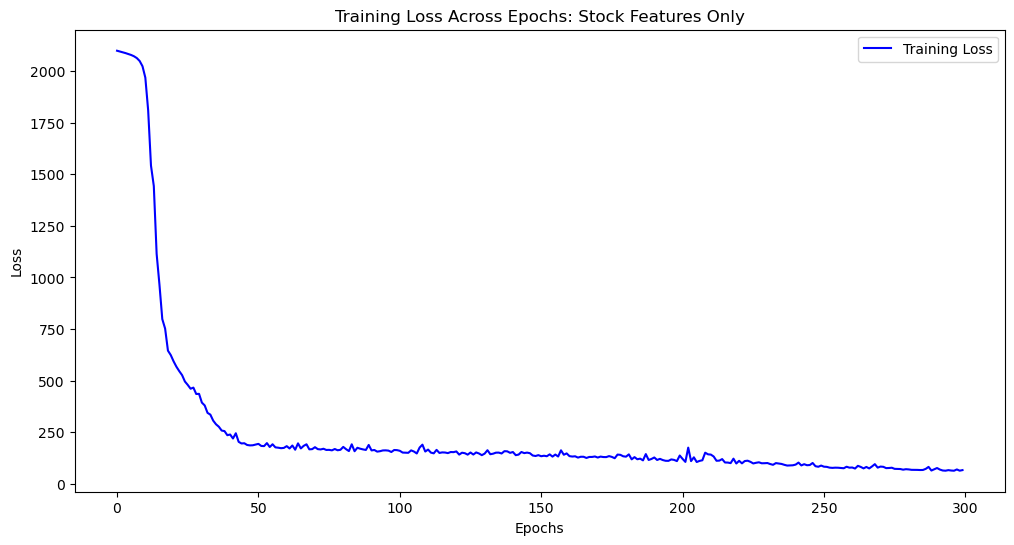

In [174]:
# Plot training loss 
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Across Epochs: Stock Features Only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [175]:
# predict for train
y_train_pred = model_lstm.predict(X_train)

# predict for test 
y_pred = model_lstm.predict(X_test)

# Calculate MSE, RMSE, and MAE for train
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)

# Calculate same metrics for test set 
mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)

# display
print("Training Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_train, rmse_train, mae_train))

print("\nTest Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_test, rmse_test, mae_test))



2/2 [==============================] - 0s 2ms/step
Training Set Metrics:
MSE: 66.0795, RMSE: 8.1289, MAE: 5.9267

Test Set Metrics:
MSE: 26.4897, RMSE: 5.1468, MAE: 4.3958


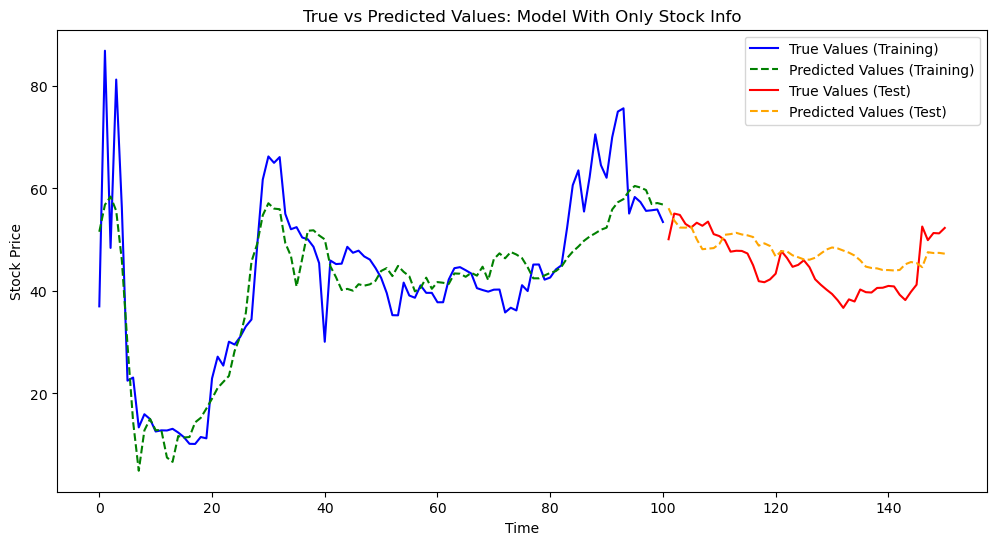

In [176]:
# Plot predicted vs true values for training and test sets
plt.figure(figsize=(12, 6))

# Plot training set
plt.plot(y_train, label='True Values (Training)', color='blue')
plt.plot(y_train_pred, label='Predicted Values (Training)', color='green', linestyle='--')

# Plot test set
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='True Values (Test)', color='red')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, label='Predicted Values (Test)', color='orange', linestyle='--')

plt.title('True vs Predicted Values: Model With Only Stock Info')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



Overall this model performed decently. The Test MSE actually lower than the training MSE, but this may be due to the large nmber of strange fluctuations during the training period. When we look at the plot of predicted versus actual values, the difference does not seem too dramatic. However, the model does appear to overestimate the stock price for a majority of the forecasting period. Overall, it seems the model does not capture the noise of the stock prices too well, and tends to overestimate. Although the low test MSE raises concerns of overfitting, this doesn't seem to be the case when we plot the predicted vs actual. 

#### Model 2: Just Sentiment Analysis Data to predict the stock price

In [177]:
#split data into x and y 
X_sent = reddit_full.drop(columns=['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 
                                    'Volume', 'Previous_Close', 'Previous_Volume'])
y_sent = reddit_full['Close'].values

#scale the x features
scaler_X = MinMaxScaler()
X_scaled_sent = scaler_X.fit_transform(X_sent)

In [178]:
# Creating the sequences 
X_sequences_sent, y_sequences_sent = [], []

sequence_length = 14

for i in range(len(X_scaled_sent) - sequence_length):
    X_seq_sent = X_scaled_sent[i:i + sequence_length]
    y_seq_sent = y_sent[i + sequence_length] 
    X_sequences_sent.append(X_seq_sent)
    y_sequences_sent.append(y_seq_sent)

X_sequences_sent, y_sequences_sent = np.array(X_sequences_sent), np.array(y_sequences_sent)

In [179]:
# Split the data into training and testing based on the dates for forecasting period
split_date = '2021-06-01'  
split_index = reddit_full.index.get_loc(split_date)

X_train_sent, y_train_sent = X_sequences_sent[:split_index], y_sequences_sent[:split_index]
X_test_sent, y_test_sent = X_sequences_sent[split_index:], y_sequences_sent[split_index:]

In [180]:
# Build the LSTM
sent_lstm = Sequential()
sent_lstm.add(LSTM(units=40, activation='relu', input_shape=(X_train_sent.shape[1], X_train_sent.shape[2])))
sent_lstm.add(Dense(units=1))  
sent_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
history = sent_lstm.fit(X_train_sent, y_train_sent, epochs=100, batch_size=32)

Epoch 1/100


3/3 [==============================] - 0s 3ms/step - loss: 2086.1641
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 2071.8542
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 2055.6204
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 2035.3081
Epoch 5/100
3/3 [==============================] - 0s 3ms/step - loss: 2007.9614
Epoch 6/100
3/3 [==============================] - 0s 2ms/step - loss: 1967.3392
Epoch 7/100
3/3 [==============================] - 0s 2ms/step - loss: 1896.3311
Epoch 8/100
3/3 [==============================] - 0s 2ms/step - loss: 1740.5629
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 1266.3750
Epoch 10/100
3/3 [==============================] - 0s 2ms/step - loss: 529.7720
Epoch 11/100
3/3 [==============================] - 0s 2ms/step - loss: 547.5277
Epoch 12/100
3/3 [==============================] - 0s 2ms/step - loss: 417.8492
Epoch 13/100
3/3 [======================

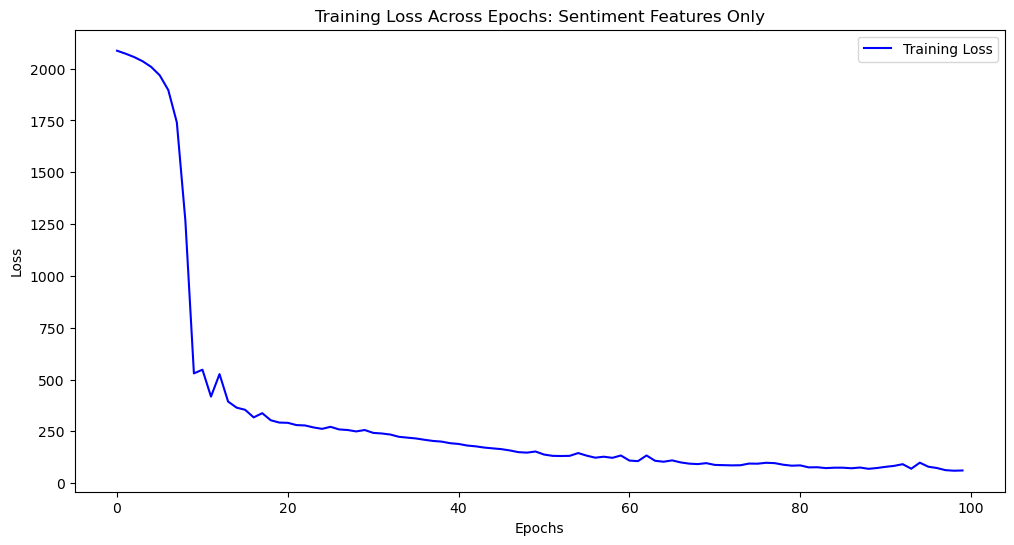

In [181]:
# Plot training loss 
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Across Epochs: Sentiment Features Only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [182]:
# predict for train
y_train_pred_sent = sent_lstm.predict(X_train_sent)

# predict for test 
y_pred_sent = sent_lstm.predict(X_test_sent)

# Calculate MSE, RMSE, and MAE for train
mse_train = mean_squared_error(y_train_sent, y_train_pred_sent)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_sent, y_train_pred_sent)

# Calculate same metrics for test set 
mse_test = mean_squared_error(y_test_sent, y_pred_sent)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_sent, y_pred_sent)

# display
print("Training Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_train, rmse_train, mae_train))

print("\nTest Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_test, rmse_test, mae_test))



2/2 [==============================] - 0s 2ms/step
Training Set Metrics:
MSE: 58.3999, RMSE: 7.6420, MAE: 5.8465

Test Set Metrics:
MSE: 60.1474, RMSE: 7.7555, MAE: 6.5662


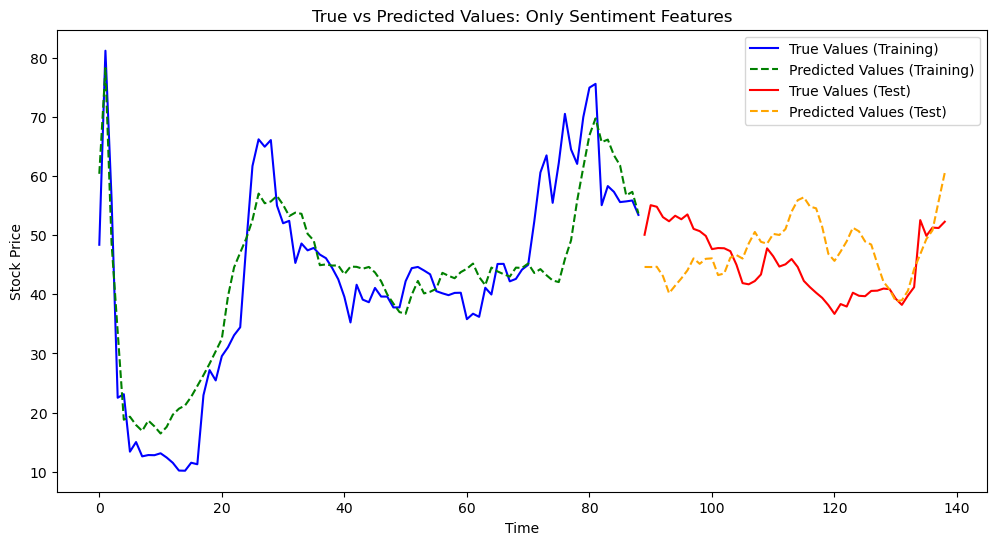

In [183]:
# Plot predicted vs true values for training and test sets
plt.figure(figsize=(12, 6))

# Plot training set
plt.plot(y_train_sent, label='True Values (Training)', color='blue')
plt.plot(y_train_pred_sent, label='Predicted Values (Training)', color='green', linestyle='--')

# Plot test set
plt.plot(np.arange(len(y_train_sent), len(y_train_sent) + len(y_test_sent)), y_test_sent, label='True Values (Test)', color='red')
plt.plot(np.arange(len(y_train_sent), len(y_train_sent) + len(y_test_sent)), y_pred_sent, label='Predicted Values (Test)', color='orange', linestyle='--')

plt.title('True vs Predicted Values: Only Sentiment Features')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



Compared to the previous model that used the previous day's stock information to predict today's closing price, this model performed worse. The test MSE is higher than the train MSE. This model exclusively used information related to the sentiment of reddit posts aggregated at the daily level to predict the closing stock price. In the initial days of the forecasting period, the model underestimated the stock price, but for the rest of the forecasting period, the model tends to overestimate the price of the stock. It is possible that during the beginning days of the forecasting period, there was strong negative sentiments expressed on reddit. Then, the sentiment may have improved thus causing the model to overestimate the stock price. Overall, this model seems to capture more of the noise of the data in its predictions. 

#### Model 3: Combining the stock information with the Sentiment Information to create a fusion model

In [184]:
# Split data into x and y 
X_full = reddit_full.drop(columns=['date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 
                                    'Volume'])
y_full = reddit_full['Close'].values

# Scale the x features
scaler_X = MinMaxScaler()
X_scaled_full = scaler_X.fit_transform(X_full)

In [185]:
# create the sequences
X_sequences_full, y_sequences_full = [], []

sequence_length = 14

for i in range(len(X_scaled_full) - sequence_length):
    X_seq_full = X_scaled_full[i:i + sequence_length]
    y_seq_full = y_full[i + sequence_length] 
    X_sequences_full.append(X_seq_full)
    y_sequences_full.append(y_seq_full)

X_sequences_full, y_sequences_full = np.array(X_sequences_full), np.array(y_sequences_full)

In [186]:
# Split the data into training and testing based on the dates for forecasting period
split_date = '2021-06-01'  
split_index = reddit_full.index.get_loc(split_date)

X_train_full, y_train_full = X_sequences_full[:split_index], y_sequences_full[:split_index]
X_test_full, y_test_full = X_sequences_full[split_index:], y_sequences_full[split_index:]

In [187]:
# Build the LSTM
full_lstm = Sequential()
full_lstm.add(LSTM(units=40, activation='relu', input_shape=(X_train_full.shape[1], X_train_full.shape[2])))
full_lstm.add(Dense(units=1))  
full_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM
history = full_lstm.fit(X_train_full, y_train_full, epochs=400, batch_size=32)

Epoch 1/400
3/3 [==============================] - 0s 3ms/step - loss: 2117.1348
Epoch 2/400
3/3 [==============================] - 0s 3ms/step - loss: 2102.1511
Epoch 3/400
3/3 [==============================] - 0s 3ms/step - loss: 2088.7493
Epoch 4/400
3/3 [==============================] - 0s 4ms/step - loss: 2075.9790
Epoch 5/400
3/3 [==============================] - 0s 4ms/step - loss: 2061.0093
Epoch 6/400
3/3 [==============================] - 0s 3ms/step - loss: 2042.2902
Epoch 7/400
3/3 [==============================] - 0s 3ms/step - loss: 2017.2809
Epoch 8/400
3/3 [==============================] - 0s 2ms/step - loss: 1977.2942
Epoch 9/400
3/3 [==============================] - 0s 3ms/step - loss: 1906.0898
Epoch 10/400
3/3 [==============================] - 0s 2ms/step - loss: 1738.8250
Epoch 11/400
3/3 [==============================] - 0s 3ms/step - loss: 1301.8113
Epoch 12/400
3/3 [==============================] - 0s 3ms/step - loss: 506.0508
Epoch 13/400
3/3 [========

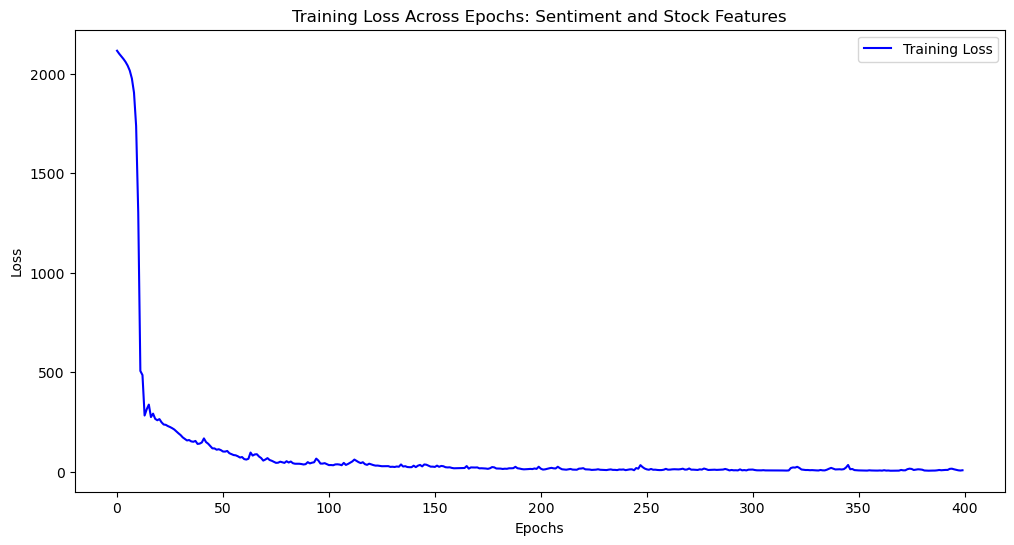

In [188]:
# plot training loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Across Epochs: Sentiment and Stock Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [189]:
# predict for train 
y_train_pred_full = full_lstm.predict(X_train_full)

# predict for test 
y_pred_full = full_lstm.predict(X_test_full)

# calculate required metrics for train
mse_train = mean_squared_error(y_train_full, y_train_pred_full)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_full, y_train_pred_full)

# calculate same metrics for test set 
mse_test = mean_squared_error(y_test_full, y_pred_full)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_full, y_pred_full)

# display
print("Training Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_train, rmse_train, mae_train))

print("\nTest Set Metrics:")
print("MSE: {:.4f}, RMSE: {:.4f}, MAE: {:.4f}".format(mse_test, rmse_test, mae_test))



2/2 [==============================] - 0s 2ms/step
Training Set Metrics:
MSE: 7.4344, RMSE: 2.7266, MAE: 2.1058

Test Set Metrics:
MSE: 70.7092, RMSE: 8.4089, MAE: 6.8473


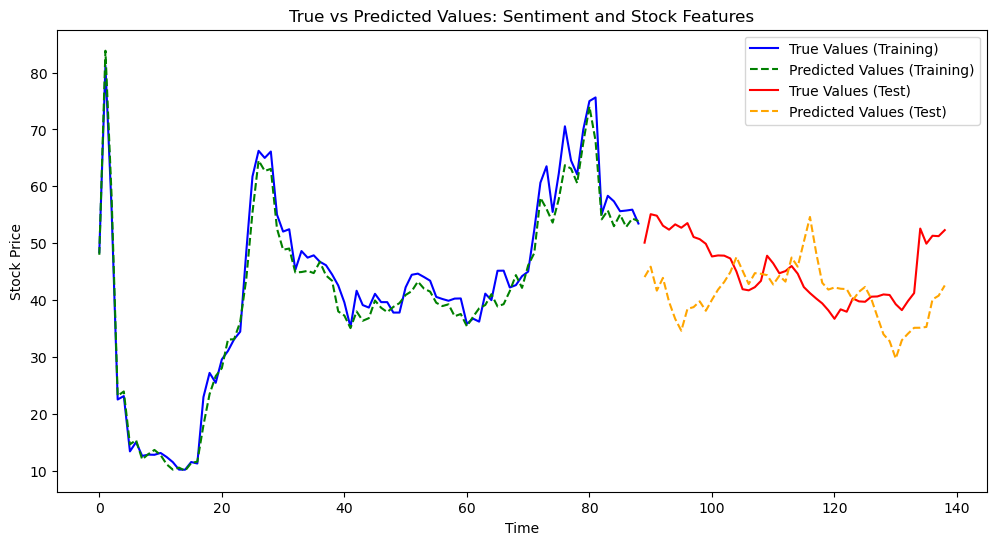

In [190]:
# Plot predicted vs actual for training and test sets
plt.figure(figsize=(12, 6))

# Plot training set
plt.plot(y_train_full, label='True Values (Training)', color='blue')
plt.plot(y_train_pred_full, label='Predicted Values (Training)', color='green', linestyle='--')

# Plot test set
plt.plot(np.arange(len(y_train_full), len(y_train_full) + len(y_test_full)), y_test_full, label='True Values (Test)', color='red')
plt.plot(np.arange(len(y_train_full), len(y_train_full) + len(y_test_full)), y_pred_full, label='Predicted Values (Test)', color='orange', linestyle='--')

plt.title('True vs Predicted Values: Sentiment and Stock Features')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Out of the three models, this model seems to have performed in the middle. The test MSE is higher than the train MSE, but it the delta is similar to that of the model with only sentiment analysis features. When we plot the predicted vs actual values, we can see it underestimates the stock prices around time period 90 (this is also what occurred in the sentiment only model). It is possible there was a dramatic lack in posts or there was extreme negative sentiment posts on those days. Compared to the model using just stock prices, this combined model captures more of the fluctuations in the stock prices. After comparing this model to the others, it seems clear that incorporating sentiment as a feature in the model seems to capture the fluctuations in stock prices much better. 

## Part 3: Gamestop Short Squeeze and Model Adaptation

- **Event Analysis**: Explore the social media landscape surrounding the GameStop short squeeze in January 2021. Analyze the volume, sentiment, and key themes of discussions on platforms like Reddit's r/WallStreetBets to understand the event's dynamics.
- **Model Sensitivity**: Investigate how the model's performance would change if exposed to data with similar characteristics to the GameStop short squeeze (e.g., sudden shifts in sentiment, high volatility). Conduct sensitivity analysis by injecting simulated spikes in social media sentiment and observing the model's predictions.
- **Algorithmic Adjustments**: Based on the event analysis and sensitivity analysis, propose concrete modifications to the existing model or feature engineering processes to improve its performance in capturing the impact of extreme social media sentiment on stock prices.

#### Event Analysis

For this part I will do some EDA to look at the trend in posts and sentiment around the gamestop stock short squeeze. This took place during January 2021. 

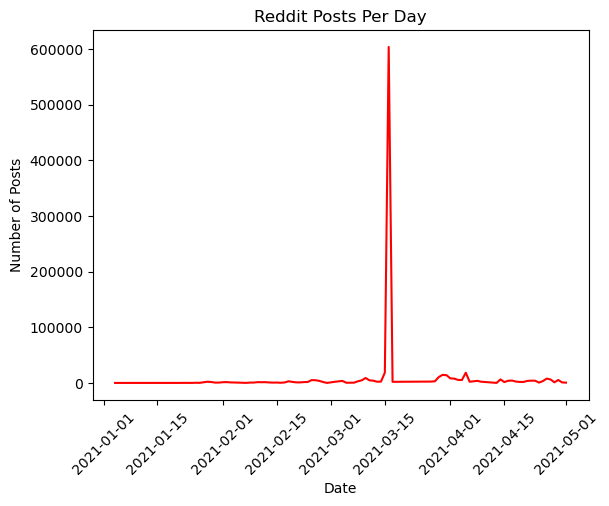

In [191]:
# lets look at the pure volume of posts per day in january- march 
# make sure date is a datetime
gamestop['date'] = pd.to_datetime(gamestop['date'])

# group by day to get number of posts per day
posts_per_day = pd.DataFrame(gamestop.groupby('date').count()['id']).reset_index()
posts_per_day = posts_per_day.rename(columns = {'id': 'n_posts'})
posts_per_day = posts_per_day[posts_per_day['date'] <= '2021-05-01']

# plot
sns.lineplot(data = posts_per_day, x = 'date', y = 'n_posts', color = 'red')
plt.title('Reddit Posts Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation = 45)
plt.show()


Interestingly, there was not a large spike in posts during Janurary, but there was a massive spike in posts during mid-March. This is not what I suspected. I thought there would be a large spike in the number of posts in january because this was the short selling period. 

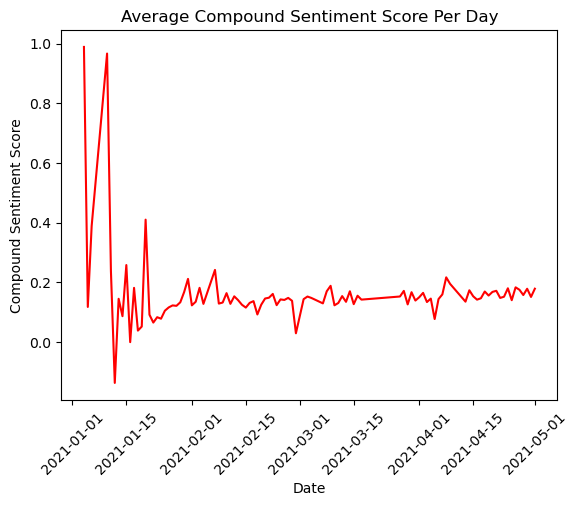

In [192]:
# Calculate avg sentiment per day 
# using compound bc it captures the pos, neg, and neutral components. 
# but I also want to see how it compares to the stock price each day. 
sent_per_day = gamestop.groupby('date').mean(numeric_only=True)[['compound']].reset_index()

# Filter dates just so its easier to examine the specific short selling period. 
sent_per_day = sent_per_day[sent_per_day['date'] <= '2021-05-01']

# setting date as index for plotting 
sent_per_day.set_index('date', inplace=True)


# Plot sentiment 
sns.lineplot(data=sent_per_day, y='compound', x=sent_per_day.index, color='red')

plt.title('Average Compound Sentiment Score Per Day')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.xticks(rotation=45)

plt.show()

Something interesting to note about the sentiment is that there is not a large shift in sentiment at the same time period there was a spike in the number of posts. The average sentiment score seems to be relatively steady after February 2021 and most volatile during January 2021. The highest sentiment scores also coincide with the short selling period which makes sense. People were discussing the stock positively and generating buzz around the stock during this time, so the sentiment scores would be highest during this period. 

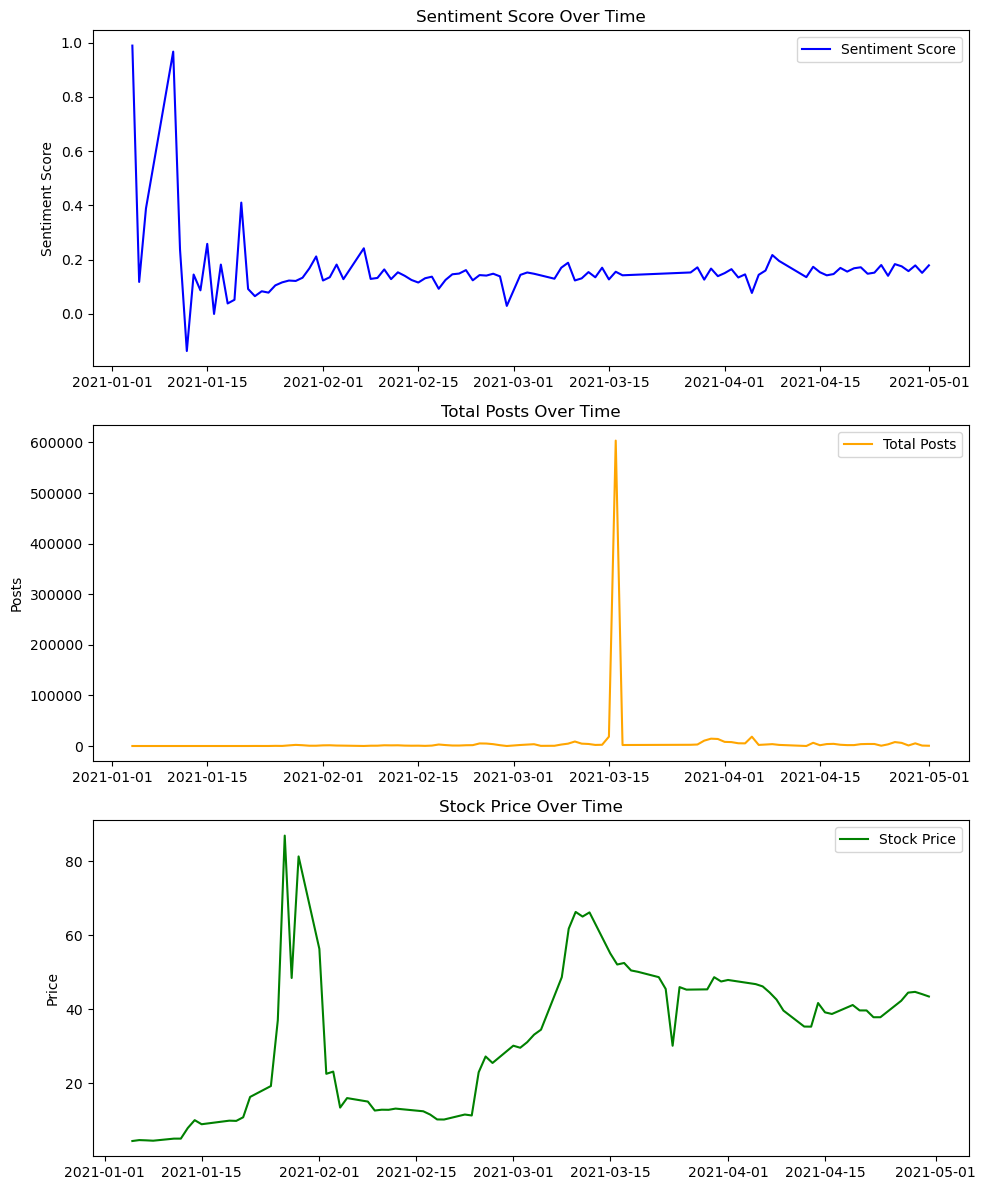

In [193]:
# Now lets look at all three together. 
# making things neat for plotting 
posts_per_day.set_index('date', inplace = True)
stock_df = stock_df.loc[:'2021-05-01']

fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plotting subplots
# Sentiment Score per Day
axes[0].plot(sent_per_day['compound'], label='Sentiment Score', color='blue')
axes[0].set_title('Sentiment Score Over Time')
axes[0].set_ylabel('Sentiment Score')
axes[0].legend()

# Total Posts per Day
axes[1].plot(posts_per_day['n_posts'], label='Total Posts', color='orange')
axes[1].set_title('Total Posts Over Time')
axes[1].set_ylabel('Posts')
axes[1].legend()


# Stock Price per Day
axes[2].plot(stock_df['Close'], label='Stock Price', color='green')
axes[2].set_title('Stock Price Over Time')
axes[2].set_ylabel('Price')
axes[2].legend()

plt.tight_layout()
plt.show()

Here I wanted to compare how the average sentiment score and total number of posts changed with the stock price during the short squeeze period. Although the sentiment scores seemed to coincide with the short selling period, once the price of the stock started to fall again, so did the overall sentiment scores. I find it interesting that the sentiment remains less volatile while the total number of posts spikes up in March. In comparing this to the stock price, one reason could be that the GME stock price started to increase again in early march, so maybe people were posting alot on reddit thinking that the same pattern would happen.

### Model Sensitivity

Spikes in sentiment may occur when there is a particular event that occurs that leads individuals to go online and write alot of positive or negative messages. For example, if Gamestop had massive layoffs, then there would likely be a massive spike in the negative sentiment score, which would thus bring down the overall compound sentiment score that is produced. One way to identify these spikes in the future would be to have a baseline for what the average sentiment is, and if there is a significant dip below or above that baseline, it would offer insight into identifying one of these spikes. Generally, the model seemed to be relatively sensitive to the sentiment scores, because there was increased fluctuations in the model when we included the sentiment features. The predictions did not seem to fluctuate as much when it was simply using the stock information to make predictions. 

### Algorithmic Adjustments

Based on my above analysis, I would propose several improvements to my model. The first improvement would be to create a binary feature to indicate whether or not there was a major announcement, major event, etc on a particular day. This would allow the model to account for these major events and the subsequent shifts in sentiment and stock price. Another improvement that could be made to this model is incorporating other features such as economic features to account for major events. For example, there are several economic factors like GDP which may be linked to stock prices. If there is a sudden shift in the U.S. economy, this would ultimately impact stock prices, and including a feature to reflect that would be useful for the model. 

## Conclusion and Future Directions

Overall I examined three different models. One model exclusively utilized stock information from the previous day such as closing price and volume, another model exclusively used NLP attributes such as sentiment and pos tags. The final model leveraged both of these types of features to create a third model to predict GME stock prices. In the end, the model using just stock information as the features performed the best. However, the fusion model still performed relatively well and was more adept at capturing the daily fluctuations in stock prices. The worst performing model was the second which used only NLP features to predict stock prices. 

One issue I see with the use of the NLP features is that the stock data was at the daily level and the reddit data was at the post level. Because of this, I needed to aggregate the NLP data to a daily level. I feel like this takes away from the detail of the sentiment analysis of each posts. An alternative to this might be count each reddit thread as a document, and get the sentiment scores for each channel. After doing this, we might want to create a feature for the sentiment scores for each reddit thread. This way it might make more sense when we aggregate by day, and we capture more of the differences across each thread. Another limitation to this dataset is that there might have been days with very few posts, and when this happens there is less information for the model to make its predictions with. 

In terms of ethical considerations for incorporating social media sentiment data, the most obvious concerns are related to privacy. For example, if something is posted in a private channel or a private reddit thread, the general public should not be able to access the details related to those posts. Furthermore, the content must be anonymized to protect sensitive data. For example, a lack of PII such as names, emails, and IP addresses. Balancing the desire for a robust dataset with ethical considerations remains an ongoing debate in the field of Machine Learning. 

There are several options to improve the performance of stock price prediction models that integrate social media sentiment. If we are looking at predicting the value of one specific stock as we did in this case, one option would be to include information about the stock market overall or other stocks that might be correlated with the performance of a particular stock. For example, including features about the previous closing prices for stocks in the S&P 500. This may provide an increased level of detail on the overall health of the stock market. One caveat to this is obviously with memestocks such as GME, where the overall trend of the stock market might not at all be related to the growth in that memestock. Another option to improve performance is what I mentioned previously: aggregate sentiment at the channel/thread level so that there is a more robust understanding of how sentiment varies by thread. One concern with this is that there may be private channels that you do not have access to/should not have access to. Another option for improvement would be to gather information from multiple social media platforms. In this case, we only used data from reddit posts. However, it might be helpful to take information from twitter or other popular social media discussion platforms. An issue with this is that different social media sights might have different privacy regulations so you may be limited in what information you can take for each platform. Finally, we could train the model on financial text rather than just reddit posts (ie financial blogs, financial reddit threads, etc). In doing so, we will better capture the sentiment as it relates to the finaincial domain. This would be useful for the model because it will aid in better capturing how the varying posts and articles might reflect the stock price. 
